In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
from torch import nn

import joblib

import sys
sys.path.append("..")

from src.model import build_autoencoder


## Load model, scaler, and test data

In [2]:
models_dir = Path("../models")

scaler = joblib.load(models_dir / "scaler.pkl")
X_test_scaled = np.load(models_dir / "X_test_scaled.npy")
y_test = np.load(models_dir / "y_test.npy")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

input_dim = X_test_scaled.shape[1]
latent_dim = 16  # must match training

model = build_autoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)
state_dict = torch.load(models_dir / "autoencoder_best.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("Model, scaler, and test data loaded.")


Using device: cpu
Model, scaler, and test data loaded.


## Compute reconstruction errors

In [5]:
def compute_reconstruction_errors(model, X, batch_size=1024, device='cpu'):
    model.eval()
    dataset = torch.from_numpy(X).to(device)
    errors = []

    with torch.no_grad():
        for i in range(0, len(dataset), batch_size):
            batch = dataset[i : i + batch_size]
            recon = model(batch)
            # MSE per sample
            batch_errors = torch.mean((batch - recon) ** 2, dim=1)
            errors.append(batch_errors.cpu().numpy())

    return np.concatenate(errors, axis=0)


errors_test = compute_reconstruction_errors(model, X_test_scaled, device=device)
errors_test.shape

(57355,)

## Visualize reconstruction error distributions

Normal samples: 56863
Fraud samples: 492


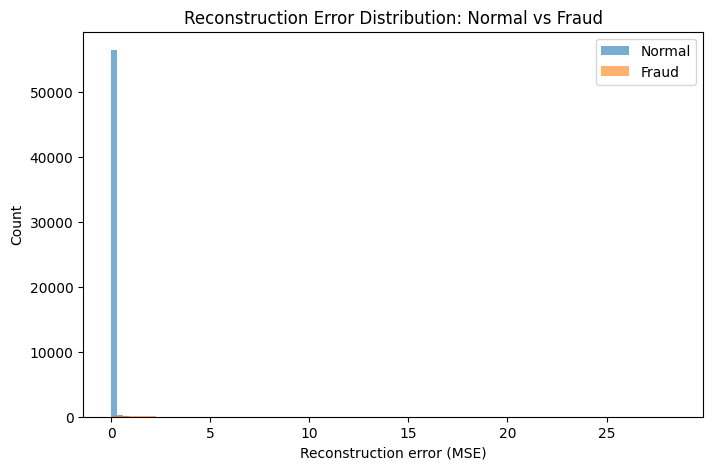

In [6]:
normal_errors = errors_test[y_test == 0]
fraud_errors = errors_test[y_test == 1]

print("Normal samples:", normal_errors.shape[0])
print("Fraud samples:", fraud_errors.shape[0])

plt.figure(figsize=(8, 5))
plt.hist(normal_errors, bins=50, alpha=0.6, label="Normal")
plt.hist(fraud_errors, bins=50, alpha=0.6, label="Fraud")
plt.xlabel("Reconstruction error (MSE)")
plt.ylabel("Count")
plt.title("Reconstruction Error Distribution: Normal vs Fraud")
plt.legend()
plt.show()


In [7]:
threshold = np.percentile(normal_errors, 99.5)
threshold


np.float32(0.34758765)

In [8]:
y_pred = (errors_test > threshold).astype(int)  # 1 = anomaly

print("Predicted anomalies:", y_pred.sum())
print("True anomalies:", (y_test == 1).sum())


Predicted anomalies: 667
True anomalies: 492


In [10]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
cm


array([[56578,   285],
       [  110,   382]])

In [12]:
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Confusion Matrix:
[[56578   285]
 [  110   382]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9981    0.9950    0.9965     56863
         1.0     0.5727    0.7764    0.6592       492

    accuracy                         0.9931     57355
   macro avg     0.7854    0.8857    0.8279     57355
weighted avg     0.9944    0.9931    0.9936     57355



In [13]:
# indices sorted by error descending
idx_sorted = np.argsort(errors_test)[::-1]

print("Top 5 highest-error samples:")
for i in idx_sorted[:5]:
    print(f"Index: {i}, Error: {errors_test[i]:.6f}, True label: {y_test[i]}")


Top 5 highest-error samples:
Index: 57205, Error: 28.456236, True label: 1.0
Index: 57200, Error: 27.847734, True label: 1.0
Index: 57198, Error: 19.039021, True label: 1.0
Index: 46372, Error: 14.892814, True label: 0.0
Index: 56907, Error: 13.132501, True label: 1.0
